# Tomography

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

## 0) Loading the data

To solve the task, we first need to load the lists of angles and the measured sensor data (and define $M$s so we have all required information to solve the problem).

In [2]:
Nps = [109, 275]
Ms = [77, 195]
alpha_lists = [np.load(f"data/alphas_{M}.npy") for M in Ms]
ys = [np.load(f"data/y_{M}.npy") for M in Ms]

print("Loaded the following datasets:\n")

for i, (Np, M, alphas) in enumerate(zip(Nps, Ms, alpha_lists)):
    print(f"{i}) sensor size {Np}, {len(alphas)} measurements, image size {M}.")
    print(f"  - N = {Np} * {len(alphas)} = {Np * len(alphas)}")
    print(f"  - D = M^2 = {M ** 2}\n")

Loaded the following datasets:

0) sensor size 109, 90 measurements, image size 77.
  - N = 109 * 90 = 9810
  - D = M^2 = 5929

1) sensor size 275, 179 measurements, image size 195.
  - N = 275 * 179 = 49225
  - D = M^2 = 38025



## 1) Constructing the matrix X

Now we can start constructing the $X$ matrix, as described in the task. We need to use the `scipy.sparse` tools to do so, since the matrix will be large.

In [3]:
def construct_X(M, alphas, Np = None) -> scipy.sparse.coo_matrix:
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        
    N = Np * len(alphas)
    D = M ** 2
    
    data = []
    i_indexes = []
    j_indexes = []
    
    # for each angle, calculate the contributions of the rows of the image to the sensor
    c_point = M / 2
    c_sensor = Np / 2

    for i, alpha in enumerate(alphas):
        v_alpha = np.cos(np.deg2rad(alpha)), np.sin(np.deg2rad(alpha))
        
        for row in range(M):
            offset_row = -(row - c_point) - 0.5
            for column in range(M):
                offset_column = (column - c_point) + 0.5
                
                # we're projecting a point (vector) onto a vector
                # since we only need the length (index of the sensor), a dot product is sufficient            
                idx = np.dot((offset_column, offset_row), v_alpha) + c_sensor - 0.5
                
                # if the ray is out of bounds, we don't want to include it
                # this is necessary because the larger set has out-of-bounds rays
                s1_valid = 0 <= idx
                s2_valid = idx <= Np
        
                # distribute among the 2 affected sensors
                s1_pos = int(idx)
                s2_pos = int(idx + 1)
                
                s1_val = 1 - (idx - s1_pos)
                s2_val = 1 - (s2_pos - idx)
                
                if s1_valid:
                    data.append(s1_val)
                    i_indexes.append(s1_pos + i * Np)
                    j_indexes.append(column + row * M)
                    
                if s2_valid:
                    data.append(s2_val)
                    i_indexes.append(s2_pos + i * Np)
                    j_indexes.append(column + row * M)

    return scipy.sparse.coo_matrix((data, (i_indexes, j_indexes)), shape=(N, D), dtype=np.float32)

Now we can check the implementation with the provided `X_example.npy` matrix to see if the construction works:

Text(0.5, 1.0, 'Example X')

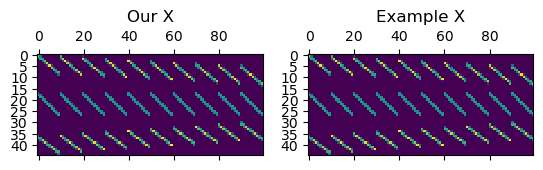

In [4]:
X = construct_X(10, [-33, 1, 42]).toarray()
X_example = np.load(f"data/X_example.npy")

# the matrices should match
assert np.isclose(X, X_example).all()

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.matshow(X)
ax1.set_title('Our X')

ax2.matshow(X_example)
ax2.set_title('Example X')

It seems that the matrices match so we can calculate the full $X$ matrix for our task.

In [5]:
dataset = 1  # 0 for smaller, 1 for larger

start = time.time()

M = Ms[dataset]
alphas = alpha_lists[dataset]
Np = Nps[dataset]
y = ys[dataset]

X = construct_X(M, alphas, Np)
print(f"Constructed X of size {X.shape} in {time.time() - start:.02f}s")

Constructed X of size (49225, 38025) in 29.15s


## 2) Recovering the image

Now that $X$ has been computed, we can use least squares to reconstruct the image.
We'll use the sparsity of $X$ to our advantage:

In [6]:
nonzero = X.count_nonzero()
total = np.prod(X.shape)

print(f"X has {nonzero} non-zero values out of {total} total ({nonzero / total * 100:.02f}%)")

X has 13535943 non-zero values out of 1871780625 total (0.72%)


Now we can finally run least squares using scipy's `sparse.linalg.lsqr`, obtaining the image:

In [7]:
start = time.time()

# use csc representation, which is much faster for calculating least squares
result = scipy.sparse.linalg.lsqr(X.tocsc(), y)

print(f"Solved sparse least squares in {time.time() - start:.02f}s")

Solved sparse least squares in 73.20s


which we can plot:

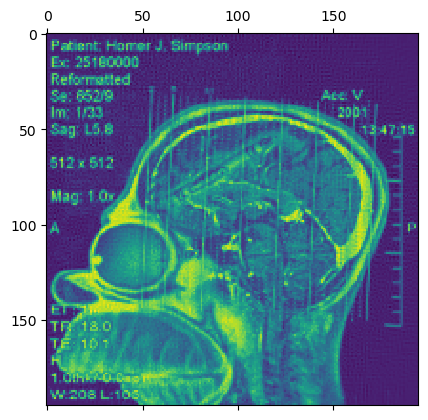

In [8]:
beta = np.reshape(result[0], (M, M))

plt.matshow(beta)

This result is quite surprising since Homer Simpson's brain seems to be of regular size.